# Jupyter extensions installation

## nbextensions

Open a terminal and execute : 


```
#!/bin/bash
 
sudo -H -i -u ec2-user bash << EOF
 
echo "Install jupyter nbextension"
source /home/ec2-user/anaconda3/bin/activate JupyterSystemEnv
pip install jupyter_contrib_nbextensions
jupyter contrib nbextensions install --user
 
echo "Restarting jupyter notebook server"
pkill -f jupyter-notebook
 
echo "Finished running onStart script"
EOF
```

then you shall see a tab nbextension appearing in the jupyter landing page

## Memory usage display in jupyter

Again, open terminal and type 

```
source /home/ec2-user/anaconda3/bin/activate JupyterSystemEnv
pip install nbresuse
```

this should add nbresuse in the extension manager. It's necessary to shutdown/restart the notebook if it was running after installing the extensions for the memory to be displayed

# Package installation

In [1]:
!pip install seaborn==0.10.1
!pip install -U scikit-learn
!pip install --upgrade pandas 
!pip install --upgrade s3fs

    100% |████████████████████████████████| 225kB 12.9MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 6.9MB 6.8MB/s eta 0:00:01
    100% |████████████████████████████████| 307kB 40.3MB/s ta 0:00:01
Requirement not upgraded as not directly required: scipy>=0.19.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.1.0)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.14.6)
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, h

# IMPORT

In [1]:
# import libraries here; add more as necessary
import os
import io

from time import gmtime, strftime

import  csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import re
from joblib import dump, load

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from scipy import sparse

import sagemaker
import boto3
from sagemaker import PCA,KMeans
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.amazon.common import write_spmatrix_to_sparse_tensor
from sagemaker.s3 import S3Uploader
import mxnet as mx



# magic word for producing visualizations in notebook
%matplotlib inline

# CUSTOM FUNCTIONS

In [2]:
from utils.custom_transformers import cleaning, naning, low_freq
from utils.helper import *

# DATA STORAGE TO S3

In [3]:
session = sagemaker.session.Session()

role = sagemaker.get_execution_role()

bucket = 'auto-ml-exploration'

In [13]:
s3_dataset_path = f's3://{bucket}/dataset'

sagemaker.s3.S3Uploader.upload('Udacity_AZDIAS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_CUSTOMERS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TEST.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TRAIN.csv', s3_dataset_path)

# LOAD DATA

## Data location

In [22]:
# data location on S3
pop_dataset_loc = f's3://{bucket}/dataset/Udacity_AZDIAS_052018.csv'
customers_dataset_loc = f's3://{bucket}/dataset/Udacity_CUSTOMERS_052018.csv'

## Partial loading

In [6]:
# partial loading
# load in the data, first only a few rows to get an idea
# I had a memory issue when loading the complete file
# 1 every 2 rows
pop_df_partial = pd.read_csv(pop_dataset_loc, sep=';', skiprows = lambda x: x%2) # skiprows because much data... Let's see if one can convert some to categorical to reduce memory usage

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
customers_df_partial = pd.read_csv(customers_dataset_loc, sep=';', skiprows = lambda x: x%2)

## Mini loading

In [ ]:
pop_df_mini = pop_df_partial.iloc[0:100,:]
customers_df_partial = customers_df_partial.iloc[0:100,:]

## Full loading

In [6]:
pop_df = pd.read_csv(pop_dataset_loc, sep=';')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
customers_df = pd.read_csv(customers_dataset_loc, sep=';')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Save to pickle for further usage

In [24]:
INIT_DATA_FOLDER = 'initial_data' 
INITIAL_DATA_SAVEPTH_S3 = f's3://{bucket}/{INIT_DATA_FOLDER}'

In [ ]:
pop_df.to_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/pop_complete_df.pkl')

In [25]:
customers_df.to_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/customers_complete_df.pkl')

## Data selection

In [56]:
flag = 'pop' # 'pop' or 'customers'

 # used to perform correct operations depending on dataset to be analyzed

### Live sessions

In [28]:
data_selected = customers_df #pop_df, pop_df_partial, customers_df, ...

### cold sessions

In [57]:
INIT_DATA_FOLDER = 'initial_data' 
INITIAL_DATA_SAVEPTH_S3 = f's3://{bucket}/{INIT_DATA_FOLDER}'

data_selected = pd.read_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/{flag}_complete_df.pkl')

In [10]:
data_selected = data_selected.sample(50000) # if for trial, could reduce the amount of data to speed up process

# Clean Data

Following data cleaning is performed based on the insights gained from data exploration notebook

In [43]:
to_drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'VERDICHTUNGSRAUM', 
                           'ALTERSKATEGORIE_FEIN','EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN']

if flag == 'customers' :
    data_selected.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1) # bring customers data identical to population data

# explanations
# 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015' are dropped because they are redundant regarding given information with 'CAMEO_DEU_INTL'
# 'VERDICHTUNGSRAUM' : many 0s (supposedly = unkown), many categories (impairing one hot encoding)
# 'ALTERSKATEGORIE_FEIN' : Age category Fine ... Similar to ALTER_HH from my understanding
# 'EINGEFUEGT_AM' : seems to be the time of input of the data, many categories
# 'LP_LEBENSPHASE_FEIN' : provide similar info as CAMEO & many categories

all_columns = data_selected.columns

<span style="color:red">CAREFUL</span> Don't execute below cell on customer data. Use the fitted pipeline on population data to perform identical operations on customers data !

In [35]:
# ! naning class DOES NOT respect scikit-learn conventions
# since it returns a pandas.DataFrame and not a numpy.array
clean_pipeline = make_pipeline(naning(attribute_filepath = 'DIAS Attributes - Values 2017.xlsx'),
                               cleaning(to_drop = to_drop,
                                        attribute_filepath = 'DIAS Attributes - Values 2017.xlsx'))

transformers = [
('all', clean_pipeline, all_columns),
]

combined_pipe = ColumnTransformer(transformers, remainder='drop')

In [44]:
if flag == 'pop':
    print(f"Executing {flag} pipeline")
    cleaned_data = combined_pipe.fit_transform(data_selected)
    dump(combined_pipe, 'cleaning_pipeline.joblib')
    
    # and upload those to S3 as well
    sagemaker.s3.S3Uploader.upload(f'cleaning_pipeline.joblib', 
                               f'{CLEANED_DATA_SAVEPTH_S3}')
else:
    print(f"Executing {flag} pipeline")
    sagemaker.s3.S3Downloader.download(f'{CLEANED_DATA_SAVEPTH_S3}/cleaning_pipeline.joblib', '.')
    combined_pipe = load('cleaning_pipeline.joblib') 
    
    cleaned_data = combined_pipe.transform(data_selected)
    
    # note : above code in else condition will throw a warning from scikit stating feature/column 
    # names or counts do not match the ones from the fitted pipeline
    # this has been checked ... Warning seems not applicable
    # this would have to be checked further why warning is raised but for current project at least
    # this shall not cause any problem in analysis/results
    

Executing customers pipeline


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


88 replacements made
Before deletion of full empty rows, we have 191652 samples in DataFrame data
After deletion of full empty rows, we have 191652 samples in DataFrame data
before cleaning : 366 columns, after cleanning : 288 columns


In [48]:
columns = combined_pipe.named_transformers_['all'].named_steps['cleaning'].get_feature_names() 

# note : functions exist in utils/helper.py to get the features from a columnTransformer
# However, current implementation breaks because columns are dropped in last step
# and implemented functions are not able to understand that

# either the helper function or the custom scikit transformer shall be adapted to 
# provide a better way of getting features names back

In [49]:
cleaned_data = pd.DataFrame(cleaned_data, 
             columns=columns)

In [50]:
CLEANED_DATA_FOLDER = 'cleaned_data' 
CLEANED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}'
cleaned_data.to_pickle(f'{CLEANED_DATA_SAVEPTH_S3}/{flag}_complete_cleaned_df.pkl')

In [51]:
# also save index & columns for later use
# since no more deletion/transformation on those
with open(f"columns_{flag}_cleaned.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(cleaned_data.columns.values)
    
with open(f"index_{flag}_cleaned.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(cleaned_data['LNR'].values) # index is contained in LNR columns
    
    
# and upload those to S3 as well
sagemaker.s3.S3Uploader.upload(f'columns_{flag}_cleaned.csv', 
                               f'{CLEANED_DATA_SAVEPTH_S3}')

sagemaker.s3.S3Uploader.upload(f'index_{flag}_cleaned.csv', 
                               f'{CLEANED_DATA_SAVEPTH_S3}')

's3://auto-ml-exploration/cleaned_data/index_customers_cleaned.csv'

## Removing insignificant columns - again, after cleaning

In [ ]:
# this has been checked, zero column to remove following cleaning steps -> cleaning steps effective

# not to be performed because if columns are indeed removed, this would mess up the previously
# saved data (columns list for example)

# Imputing missing data

Now Moving to scikit -> column & index will be lost since scikit works with arrays
That's why they were saved to S3 in the previous steps just after cleaning

In [46]:
TRANSFORMED_DATA_FOLDER = 'transformed_data'

## Cold start

In [74]:
# in case a cold start is needed 
flag = 'customers' # 'pop' or 'customers'

CLEANED_DATA_FOLDER = 'cleaned_data' 
CLEANED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}'

cleaned_data = pd.read_pickle(f'{CLEANED_DATA_SAVEPTH_S3}/{flag}_complete_cleaned_df.pkl')
cleaned_data = cleaned_data.astype(cleaned_data.infer_objects().dtypes)

# IF NECESSARY TO RECONSTRUCT COLUMNS
# reconstructed = pd.read_pickle('pop_cleaned_df.pkl')

# with open("columns_population_cleaned.csv","r") as f:
#     columns = f.read().split('\n')

# with open("index_population_cleaned.csv","r") as f:
#     index = f.read().split('\n')
    
# reconstructed.columns = columns
# reconstructed.set_index = index

# reconstructed = reconstructed.astype(reconstructed.infer_objects().dtypes)

## Identifying categorical vs numeric for further post-treatment

In [75]:
# First, pop identification column (LNR)
cleaned_data.drop('LNR', axis=1, inplace=True)

In [68]:
filename = 'DIAS Attributes - Values 2017.xlsx'
data_df_numeric = identify_numeric_from_filename(filename, cleaned_data) # based on Excel file
data_df_cat = [col for col in cleaned_data.columns if col not in data_df_numeric]

## Grouping low frequency categories

In [76]:
PIPELINE_NAME = "low_frequency_pipeline"
if flag == 'pop':
    print(f"Executing {flag}  {PIPELINE_NAME}")
    low_freq_cleaner = low_freq()
    transformed_data = low_freq_cleaner.fit_transform(cleaned_data)
    dump(low_freq_cleaner, f'{PIPELINE_NAME}.joblib')
    
    # and upload those to S3 as well
    sagemaker.s3.S3Uploader.upload(f'{PIPELINE_NAME}.joblib', 
                               f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}')
else:
    print(f"Executing {flag} {PIPELINE_NAME}")
    sagemaker.s3.S3Downloader.download(f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}/{PIPELINE_NAME}.joblib', '.')
    low_freq_cleaner = load(f'{PIPELINE_NAME}.joblib') 
    
    transformed_data = low_freq_cleaner.transform(cleaned_data) 

Executing customers low_frequency_pipeline
columns
AKT_DAT_KL
ALTER_HH
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_TITEL
ARBEIT
CJT_TYP_3
CJT_TYP_6
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_SOZIALES
D19_TECHNIK
D19_TELKO_MOBILE
D19_TELKO_ONLINE_QUOTE_12
D19_TELKO_REST
D19_TIERARTIKEL
D19_VERSAND_DATUM
D19_VERSAND_REST
D19_VERSI_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERSI_ONLINE_QUOTE_12
D19_VERSICHERUNGEN
D19_VOLLSORTIMENT
D19_WEIN_FEINKOST
EINGEZOGENAM_HH_JAHR
FINANZ_VORSOR

## Perform imputing, scaling and encoding pipelines

In [70]:
numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean', missing_values=np.nan), Normalizer())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent', missing_values=np.nan), OneHotEncoder(handle_unknown='ignore'))

In [71]:
ct = ColumnTransformer(transformers=[('categorical_transformer', categorical_pipeline, data_df_cat)]
                      )

In [77]:
PIPELINE_NAME = "imputer_scaler_encoder_pipeline"
if flag == 'pop':
    print(f"Executing {flag}  {PIPELINE_NAME}")
    X = ct.fit_transform(transformed_data) # this will be a numpy array
    
    print(f'shape of data after pipeline is {X.shape}')
    
    dump(ct, f'{PIPELINE_NAME}.joblib')
    
    # and upload those to S3 as well
    sagemaker.s3.S3Uploader.upload(f'{PIPELINE_NAME}.joblib', 
                               f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}')
else:
    print(f"Executing {flag} {PIPELINE_NAME}")
    sagemaker.s3.S3Downloader.download(f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}/{PIPELINE_NAME}.joblib', '.')
    ct = load(f'{PIPELINE_NAME}.joblib') 
    
    X = ct.transform(transformed_data)  # numpy array
    
    print(f'shape of data after pipeline is {X.shape}')


Executing customers imputer_scaler_encoder_pipeline
shape of data after pipeline is (191652, 1329)


## Send transformed data to S3 as recordIO format

In [78]:
transformed_data = X.astype('float32', copy=False)

buf = io.BytesIO()
write_spmatrix_to_sparse_tensor(buf, transformed_data) # produces a record IO in fact
buf.seek(0)

TRANSFORMED_DATA_SAVEPTH_S3 = f'{TRANSFORMED_DATA_FOLDER}/{flag}_complete_transformed_sparse'
boto3.resource('s3').Bucket(bucket).Object(TRANSFORMED_DATA_SAVEPTH_S3).upload_fileobj(buf) 

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionnality reduction

One is going to use PCA to perform dimnesionnality reduction. This algorithm is not the most appropriate for our dataset because it features a lot of categorical data and because PCA only cares about linear relationships.

Other possibilities would be using a manifold techniuqe (non-linear) or even look at embeddings.

However, since PCA is widely used and readily available in AWS, it's worth trying it and considering this as a baseline

### Configure PCA parameters & options

In [5]:
num_components=100

In [168]:
folder = 'PCA'

TRAIN_LOCATION = TRANSFORMED_DATA_SAVEPTH_S3

In [47]:
container = get_image_uri(session.boto_region_name, 'pca')

training_params = {}

training_params['RoleArn'] = role

training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + bucket + "/" + folder + "/output"
}

training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

training_params['HyperParameters'] = {
    "feature_dim" : str(X.shape[1]),
    "mini_batch_size" : str(100),
    "num_components" : str(num_components),
}

training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": TRAIN_LOCATION,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "CompressionType": "None",
        "RecordWrapperType": "None"
    },
]

### Launch training job

In [48]:
training_job_name = "capstone-population-pca-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

In [49]:
session.logs_for_job(training_job_name, wait=True)

2020-06-20 19:47:59 Starting - Starting the training job...
2020-06-20 19:48:00 Starting - Launching requested ML instances......
2020-06-20 19:49:04 Starting - Preparing the instances for training...
2020-06-20 19:49:56 Downloading - Downloading input data......
2020-06-20 19:50:52 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/20/2020 19:50:55 INFO 140326720956224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[06/20/2020 19:50:55 INFO 140326720956224] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'1329', u'mini_batch_size

[06/20/2020 19:50:56 INFO 140326720956224] nvidia-smi took: 0.0251908302307 secs to identify 0 gpus
[06/20/2020 19:50:56 INFO 140326720956224] Number of GPUs being used: 0
[06/20/2020 19:50:56 INFO 140326720956224] The default executor is <PCAExecutor on cpu(0)>.
[06/20/2020 19:50:56 INFO 140326720956224] 1329 feature(s) found in 'data'.
[06/20/2020 19:50:56 INFO 140326720956224] <PCAExecutor on cpu(0)> is assigned to batch slice from 0 to 99.
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 900.0148773193359, "sum": 900.0148773193359, "min": 900.0148773193359}}, "EndTime": 1592682656.792515, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1592682655.879239}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Tota

### Extract trained model data

#### If coming back

In [15]:
training_job_name = 'capstone-population-pca-2020-06-20-19-47-58'

#### if active session

In [16]:
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

#### Set model name

In [44]:
model_name = training_job_name + "-model"

### Create model

In [ ]:
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

### Download model artifacts

In [57]:
sagemaker.s3.S3Downloader.download(model_artifacts, '.')
os.system('tar -zxvf model.tar.gz')

### Load model artifacts

In [17]:
pca_model_params = mx.ndarray.load('model_algo-1')

### Explore model results

In [18]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [41]:
n_comp = 50
print(f'explained variance (in projected space) with {n_comp} components equals {(s.iloc[-n_comp:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()).iloc[0]}')

explained variance with 50 components equals 0.7689167261123657


In [14]:
# if needed to get columns back
sagemaker.s3.S3Downloader.download(f'{CLEANED_DATA_SAVEPTH_S3}/columns_pop_cleaned.csv', '.')
with open('columns_pop_cleaned.csv') as f:
    columns = f.read().split('\n')

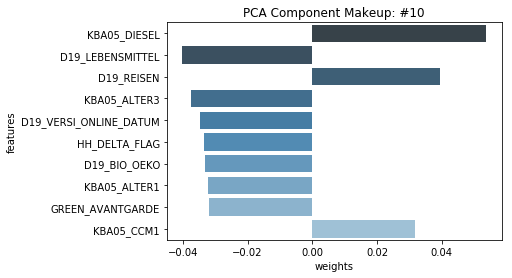

In [77]:
component_num=10

first_comp = v.iloc[-component_num]
comps = pd.DataFrame(list(zip(first_comp, columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

### Transform Job

#### Cold start

In [4]:
flag = 'customers'

CLEANED_INDEX_SAVEPTH_S3 = f's3://auto-ml-exploration/cleaned_data/index_{flag}_cleaned.csv'

num_components=100 # must correspond to the components number given in the training job
training_job_name = 'capstone-population-pca-2020-06-20-19-47-58'
model_name = training_job_name + "-model"
TRANSFORM_INPUT = f's3://auto-ml-exploration/transformed_data/{flag}_complete_transformed_sparse'

#### Perform transform on chose data

In [5]:
PCA_TRANSFORM_FOLDER_S3 = 'PCA_TRANSFORM'
TRANSFORM_OUTPUT_S3 = f"s3://{bucket}/{PCA_TRANSFORM_FOLDER_S3}/output_inference"
transform_job_name = f"pca-transform-{flag}-2"

In [85]:
job_config = {
   "BatchStrategy": "MultiRecord",
   "MaxConcurrentTransforms": 0,
   "MaxPayloadInMB": 6,
   "ModelName": model_name,
    
   "TransformInput": { 
      "CompressionType": "None",
      "ContentType": "application/x-recordio-protobuf",
      "DataSource": { 
         "S3DataSource": { 
            "S3DataType": "S3Prefix",
            "S3Uri": TRANSFORM_INPUT,
         }
      },
      "SplitType": "RecordIO"
   },
   "TransformJobName": transform_job_name,
    
   "TransformOutput": { 
      "Accept": "text/csv",
      "AssembleWith": "Line",
      "S3OutputPath": TRANSFORM_OUTPUT_S3
   },
   "TransformResources": { 
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
   }
}

In [86]:
batch_transform_job = session.sagemaker_client.create_transform_job(**job_config)

In [87]:
session.logs_for_transform_job(transform_job_name, wait=True)

......................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/21/2020 21:18:59 INFO 140228511827776] loaded entry point class algorithm.serve.server_config:config_api
[06/21/2020 21:18:59 INFO 140228511827776] nvidia-smi took: 0.025251865387 secs to identify 0 gpus
[06/21/2020 21:18:59 INFO 140228511827776] loading entry points
[06/21/2020 21:18:59 INFO 140228511827776] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[06/21/2020 21:18:59 INFO 140228511827776] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[06/21/2020 21:18:59 INFO 140228511827776] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[06/21/2020 21:18:59 INFO 140228511827776] loaded request iterator text/csv
[06/21/2020 21:18:59 INFO 140228511827776] loaded request iterator application/x-recordio

[06/21/2020 21:19:24 WARNING 140228511827776] Requesting context without setting the requested num of gpus. Using 'auto'
[06/21/2020 21:19:24 INFO 140228511827776] Number of GPUs being used: 0
[2020-06-21 21:19:24.534] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpEnyVD5/tmpq7OLyN", "epoch": 0, "duration": 94, "num_examples": 1, "num_bytes": 6290204}
[06/21/2020 21:19:24 INFO 140228511827776] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 21:19:24 WARNING 140228511827776] Requesting context without setting the requested num of gpus. Using 'auto'
[06/21/2020 21:19:24 INFO 140228511827776] Number of GPUs being used: 0
[2020-06-21 21:19:24.534] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpEnyVD5/tmpq7OLyN", "epoch": 0, "duration": 94, "num_examples": 1, "num_bytes": 6290204}
[06/21/2020 21:19:24 INFO 140228511827776] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 21:19:24 INFO 140228511827776] <PCAModel on cpu(0)> is assigned to batch slice fro

[06/21/2020 21:19:34 INFO 140228511827776] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 3770.
[06/21/2020 21:19:34 WARNING 140228511827776] Requesting context without setting the requested num of gpus. Using 'auto'
[06/21/2020 21:19:34 INFO 140228511827776] Number of GPUs being used: 0
[2020-06-21 21:19:34.717] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpbo4FT2/tmpkTc05n", "epoch": 0, "duration": 125, "num_examples": 1, "num_bytes": 6290360}
[06/21/2020 21:19:34 INFO 140228511827776] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 21:19:34 INFO 140228511827776] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 3771.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1592774374.762083, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1592774373.19129}

[2020-06-21 21:19:34.797] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpEtomDb/

#### Get data back from transform job

In [7]:
data_pca_df = pd.read_csv(f'{TRANSFORM_OUTPUT_S3}/{flag}_complete_transformed_sparse.out', 
                          header=None, 
                          converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                          num_components-1:lambda x: re.search(r"-?\d+\.\d+",x).group()}) # lambda functions clean first & last columns

# get back LNR data
sagemaker.s3.S3Downloader.download(f'{CLEANED_INDEX_SAVEPTH_S3}', '.')

with open(f"index_{flag}_cleaned.csv","r") as f:
    index = f.read().split('\n')

data_pca_df.set_index = index

#### Output to S3

In [8]:
data_pca_df.to_csv( f's3://{bucket}/{PCA_TRANSFORM_FOLDER_S3}/{flag}_pca_transformed_df.csv', index=False, header=False)

## Clustering

Clustering is made quick & dirty with the high-level API (Python SDK).
I believe it would be better to only use the low-level API (boto3) and deal with all data stored on S3 rather than using local dataframes, ... This is, I think, better regarding memory handling & consumption.

But for the sake of time, one will use here the high-level API

### Train

#### Cold start

In [14]:
flag = 'pop'

KMEANS_INPUT = f's3://auto-ml-exploration/PCA_TRANSFORM/{flag}_pca_transformed_df.csv'
pca_transformed_data = pd.read_csv(KMEANS_INPUT)

In [11]:
# define a KMeans estimator
NUM_CLUSTERS = 10
KMEANS_FOLDER = 'KMEANS'

output_path = f's3://{bucket}/{KMEANS_FOLDER}/output'

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

In [15]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = pca_transformed_data.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [16]:
kmeans.fit(kmeans_formatted_data)

2020-06-21 21:35:27 Starting - Starting the training job...
2020-06-21 21:35:29 Starting - Launching requested ML instances.........
2020-06-21 21:37:02 Starting - Preparing the instances for training...
2020-06-21 21:37:55 Downloading - Downloading input data......
2020-06-21 21:38:55 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/21/2020 21:38:58 INFO 139834737076032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_


2020-06-21 21:39:13 Uploading - Uploading generated training model
2020-06-21 21:39:13 Completed - Training job completed
Training seconds: 78
Billable seconds: 78


### Predict (using batch_transform)

In [6]:
KMEANS_INFERENCE_FOLDER = 'KMEANS_INFERENCE'
output_path = f's3://{bucket}/{KMEANS_INFERENCE_FOLDER}'

flag = 'customers'
KMEANS_INPUT = f's3://auto-ml-exploration/PCA_TRANSFORM/{flag}_pca_transformed_df.csv'

#### Cold start

In [15]:
k_means_model_data = 's3://auto-ml-exploration/KMEANS/output/kmeans-2020-06-21-21-35-27-700/output/model.tar.gz'
kmeans_model = sagemaker.KMeansModel(k_means_model_data, role, sagemaker_session=session, name = 'kmeans-1')

kmeans_transformer = kmeans_model.transformer(1, "ml.m4.xlarge", 
                                 strategy='MultiRecord', assemble_with='Line', 
                                 output_path=output_path, max_payload=6)

Using already existing model: kmeans-1


#### live start

In [15]:
# if live session
kmeans_transformer = kmeans.transformer(1, "ml.m4.xlarge", 
                                 strategy='MultiRecord', assemble_with='Line', 
                                 output_path=output_path, max_payload=6, role=role)

Using already existing model: kmeans-2020-06-21-11-00-25-489


#### Batch transform

In [29]:
kmeans_transformer.transform(KMEANS_INPUT, content_type = 'text/csv', split_type = 'Line', wait=True)

..............................................!


#### analyze clustering results

In [7]:
data_pop = f's3://{bucket}/{KMEANS_INFERENCE_FOLDER}/pop_pca_transformed_df.csv.out'
data_customers = f's3://{bucket}/{KMEANS_INFERENCE_FOLDER}/customers_pca_transformed_df.csv.out'

cluster_info_pop = pd.read_csv(data_pop, header=None, names=['closest_cluster', 'distance_to_cluster'],
               converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                      1:lambda x: re.search(r"-?\d+\.\d+",x).group()})

cluster_info_customers = pd.read_csv(data_customers, header=None, names=['closest_cluster', 'distance_to_cluster'],
               converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                      1:lambda x: re.search(r"-?\d+\.\d+",x).group()})

In [8]:
concatenated = pd.concat([cluster_info_pop.assign(dataset='population'), 
                          cluster_info_customers.assign(dataset='customers')])

concatenated.groupby(['dataset']).head()

,closest_cluster,distance_to_cluster,dataset
0,2.0,2.141613721847534,population
1,0.0,7.524132251739502,population
2,3.0,6.827966690063477,population
3,4.0,5.776719570159912,population
4,7.0,7.100958824157715,population
0,4.0,6.514408111572266,customers
1,2.0,5.2461090087890625,customers
2,4.0,7.510448455810547,customers
3,4.0,6.386721611022949,customers
4,1.0,7.057832717895508,customers


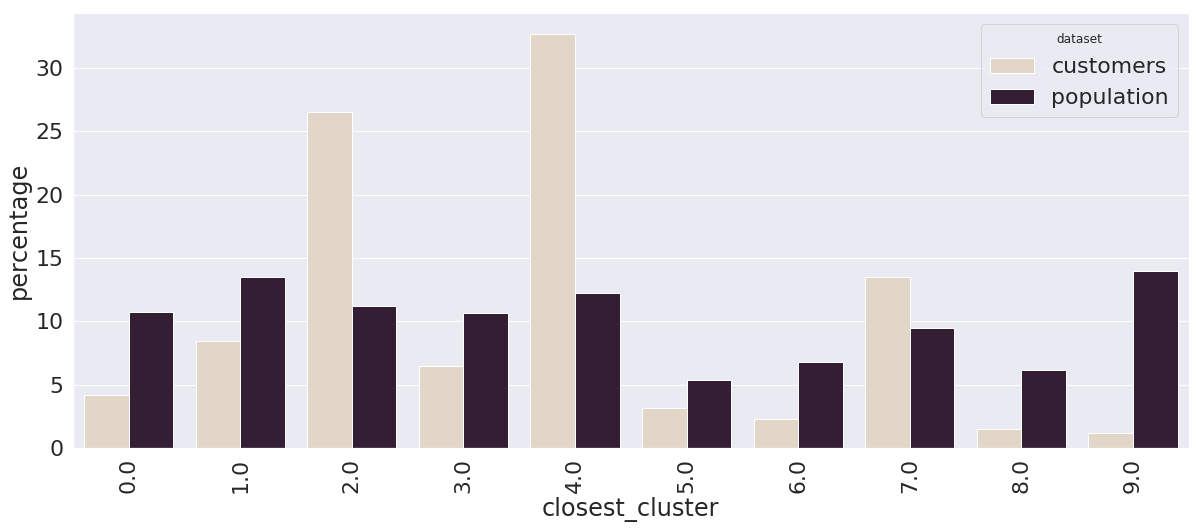

In [9]:
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x = 'closest_cluster', 
                y = 'percentage',
                hue='dataset',
                data = concatenated.groupby(['dataset'])['closest_cluster']
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values('closest_cluster'),
                palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
fig = g.get_figure()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

One sees in the graph just above that customers are present in higher numbers in clusters 2 and 4. It could be interesting to identify the features that set these clusters apart

In [26]:
# download the kmeans model file
sagemaker.s3.S3Downloader.download(k_means_model_data, '.')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

# load params
kmeans_model_params = mx.ndarray.load('model_algo-1')

# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
# get back the features information (after scaling/encoding/imputing) ? cleaning ? 
columns = pd.read_csv('s3://auto-ml-exploration/PCA_TRANSFORM/pop_pca_transformed_df.csv', header=None, nrows=1).columns

cluster_centroids.columns=columns

display(cluster_centroids)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.237306,0.407443,-0.084436,0.122783,-0.203854,0.183613,0.356455,-0.177530,-0.011536,0.209947,...,0.419081,-0.262001,0.899056,0.839044,-0.131630,3.936964,-0.190804,-1.834553,-0.753425,2.607872
1,-0.195274,0.321496,-0.036388,0.075589,-0.176227,0.108272,0.273039,-0.173382,0.005219,0.210483,...,-0.271499,0.476262,-0.420980,0.738546,-1.469844,3.541698,-0.731822,-0.701252,0.420637,1.986492
2,-0.164494,0.390487,0.005069,0.030869,-0.135863,0.115738,0.428871,-0.205076,-0.200079,0.223227,...,0.320992,-0.070331,-0.104829,0.491721,-0.929034,4.012598,-1.302858,-1.739744,2.225067,-7.256671
3,-0.254132,0.260907,-0.054447,0.100644,-0.208310,0.105699,0.168918,-0.072193,0.035590,0.147433,...,-0.895429,-0.768766,-0.367027,0.244661,-0.385371,2.221758,-0.064409,-1.305221,3.261353,1.746664
4,-0.278439,0.356014,-0.013877,0.157728,-0.156944,0.129644,0.459475,-0.115065,-0.043735,0.149909,...,0.226177,0.195016,0.386032,1.263342,-0.745675,2.239477,-0.506912,0.338857,3.831557,1.625381
5,-0.265923,0.321367,-0.030359,0.114407,-0.175046,0.105014,0.313453,-0.029900,0.022699,0.184352,...,-0.823591,1.955021,1.241043,-0.416226,1.753447,3.001693,-2.413998,-1.582600,2.572329,-0.745038
6,-0.279992,0.283541,0.025738,0.158878,-0.127442,0.037502,0.306776,-0.052194,0.044318,0.119736,...,0.680368,-1.184907,0.173185,0.518785,-0.496943,1.547585,-3.253678,-0.963164,2.467543,2.339794
7,-0.249255,0.270538,-0.004745,0.132363,-0.184815,0.162742,0.268073,-0.045736,0.081340,0.147940,...,1.320008,0.284550,-0.334458,-1.138955,-1.362347,2.381026,-0.063352,-1.042970,3.079237,1.643610
8,-0.102249,0.324969,-0.080715,0.168960,-0.103958,0.228105,0.425190,-0.146590,-0.129268,0.288405,...,0.692641,-0.841806,-0.097650,0.813811,-0.856448,3.286878,-3.527714,-0.900001,-0.647306,2.975046
9,-0.251247,0.304848,-0.009763,0.112857,-0.259473,0.116954,0.263313,-0.046667,0.043024,0.161564,...,0.520805,0.267436,-0.272143,1.579488,-0.783532,1.830986,-0.046180,-2.496099,2.275977,1.283091


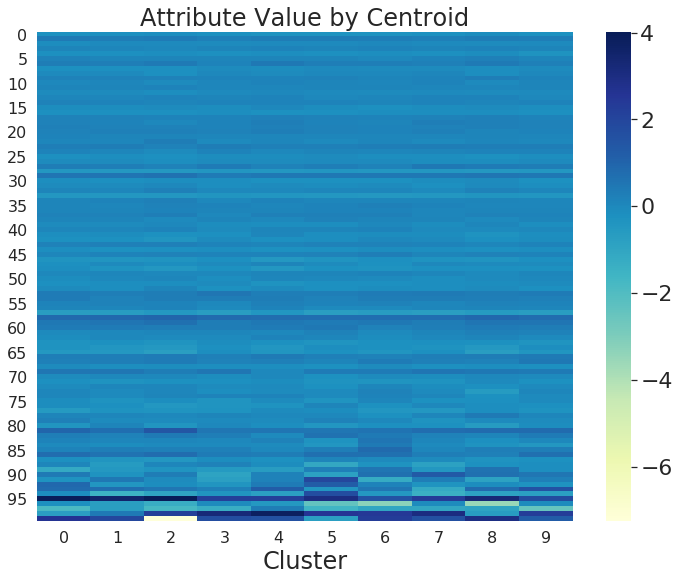

In [62]:
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [28]:
# check cluster 2 and 4 top 5 components
top = 5
top_5_cluster_2 = np.argsort(cluster_centroids.iloc[2,:])[:5]
top_5_cluster_4 = np.argsort(cluster_centroids.iloc[4,:])[:5]

In [43]:
class cd:
    """Context manager for changing the current working directory"""
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [57]:
# download the PCA model file
PCA_model_data = 's3://auto-ml-exploration/PCA/output/capstone-population-pca-2020-06-20-19-47-58/output/model.tar.gz'

DOWNLOAD_DIR = 'PCA_model'
sagemaker.s3.S3Downloader.download(PCA_model_data, DOWNLOAD_DIR)

with cd(f'{DOWNLOAD_DIR}'):
    os.system(f'tar -zxvf model.tar.gz')
    os.system(f'unzip model_algo-1')

pca_model_params = mx.ndarray.load(f'{DOWNLOAD_DIR}/model_algo-1')

v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [52]:
def display_component(v, features_list, component_num, n_weights=10):
    N_COMPONENTS = 100 # TO BE CHANGED BY USER !!
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [60]:
# get back column names in dataframe
sagemaker.s3.S3Downloader.download('s3://auto-ml-exploration/cleaned_data/columns_customers_cleaned.csv', '.')
with open('columns_customers_cleaned.csv') as f:
    columns = f.read().split('\n')[1:] # LNR is in the cleaned columns, drop it

top 0 component for cluster 2


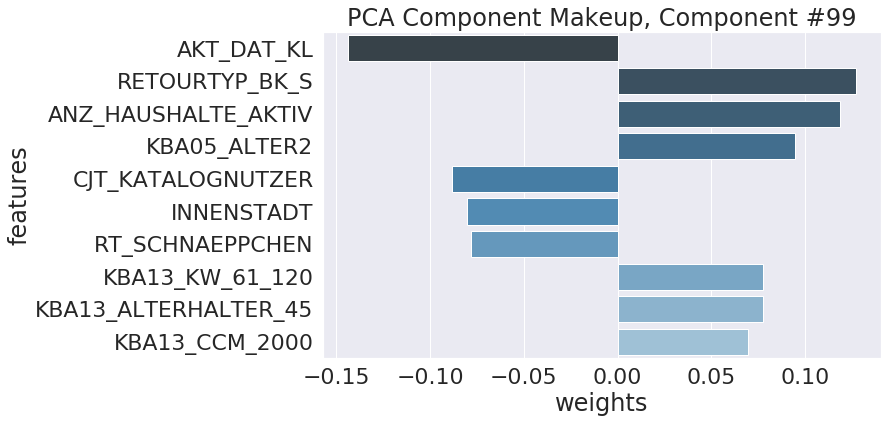

top 1 component for cluster 2


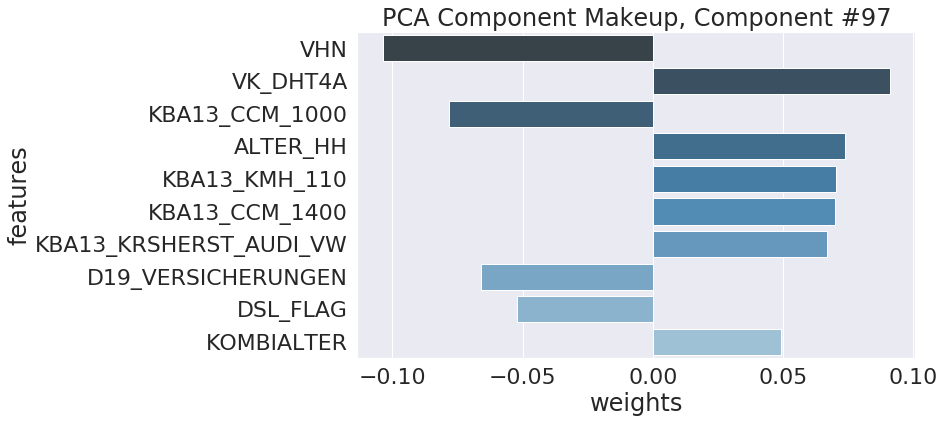

top 2 component for cluster 2


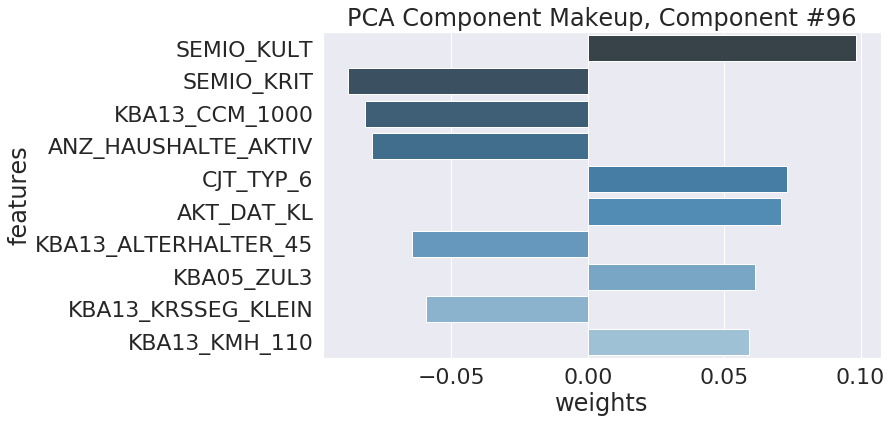

top 3 component for cluster 2


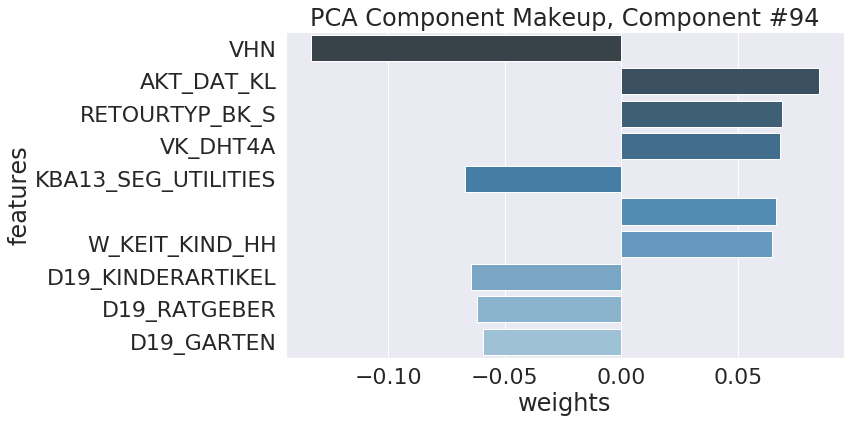

top 4 component for cluster 2


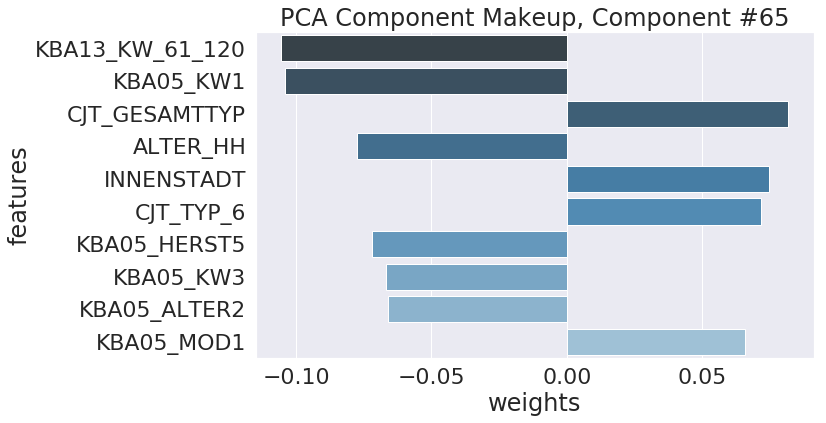

In [61]:
for i, top in enumerate(top_5_cluster_2):
    print(f'top {i} component for cluster 2')
    display_component(v, columns, component_num=top, n_weights=10)

With above analysis, one could understand which feature makes a component value increase/decrease.
Since one is analyzing the highest components in the two clusters featuring high customers density, one can then understand which features are important for someone to be a customer

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## LOAD DATA

In [64]:
mailout_train = pd.read_csv(f's3://{bucket}/dataset/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


## Quick analysis

In [67]:
# check number of customers (RESPONSE=1) and number of non-customers (RESPONSE=0)
mailout_train['RESPONSE'].value_counts()

# so ... this is a highly imbalanced dataset !
# way more non-customers than customers
# say I make a model that states "not a customer"

# Then I would automatically score an accuracy of 98% !
# accuracy ... not a good metric here ...

0    42430
1      532
Name: RESPONSE, dtype: int64

## TRANSFORM DATA

### COLD START

In [10]:
CLEANED_DATA_FOLDER = 'cleaned_data' 
CLEANED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}'

TRANSFORMED_DATA_FOLDER = 'transformed_data'

Perform identical cleaning steps compared to clustering part (use the fitted cleaning models)

Take care to take out RESPONSE column as it was not fitted.

This is ok as long as no row gets deleted (to be checked)

In [81]:
mailout_train_X = mailout_train.drop('RESPONSE', axis=1)

In [82]:
PIPELINE_NAME = "cleaning_pipeline"
print(f"Executing {PIPELINE_NAME} pipeline")
sagemaker.s3.S3Downloader.download(f'{CLEANED_DATA_SAVEPTH_S3}/cleaning_pipeline.joblib', '.')
combined_pipe = load('cleaning_pipeline.joblib') 
mailout_cleaned_data = combined_pipe.transform(mailout_train_X)

columns = combined_pipe.named_transformers_['all'].named_steps['cleaning'].get_feature_names() 
mailout_cleaned_data = pd.DataFrame(mailout_cleaned_data, 
             columns=columns)

mailout_lnr = mailout_cleaned_data['LNR']
mailout_cleaned_data.drop('LNR', axis=1, inplace=True)

PIPELINE_NAME = "low_frequency_pipeline"
print(f"Executing {PIPELINE_NAME}")
sagemaker.s3.S3Downloader.download(f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}/{PIPELINE_NAME}.joblib', '.')
low_freq_cleaner = load(f'{PIPELINE_NAME}.joblib') 
mailout_transformed_data = low_freq_cleaner.transform(mailout_cleaned_data) 

PIPELINE_NAME = "imputer_scaler_encoder_pipeline"
print(f"Executing {PIPELINE_NAME}")
sagemaker.s3.S3Downloader.download(f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}/{PIPELINE_NAME}.joblib', '.')
ct = load(f'{PIPELINE_NAME}.joblib') 
X_mailout = ct.transform(mailout_transformed_data)  # numpy array

print(f'shape of data after completed all pipelines is {X_mailout.shape}')


Executing cleaning_pipeline pipeline
88 replacements made
Before deletion of full empty rows, we have 42962 samples in DataFrame data
After deletion of full empty rows, we have 42962 samples in DataFrame data
before cleaning : 366 columns, after cleanning : 288 columns
Executing customers low_frequency_pipeline
columns
AKT_DAT_KL
ALTER_HH
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_TITEL
ARBEIT
CJT_TYP_3
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_SOZIALES
D19_TECHNIK
D19_TELKO_MOBILE
D19_TELKO_

In [87]:
# send transformed data to S3
X_mailout = X_mailout.astype('float32', copy=False)

buf = io.BytesIO()
write_spmatrix_to_sparse_tensor(buf, X_mailout) # produces a record IO in fact
buf.seek(0)

TRANSFORMED_DATA_SAVEPTH_S3 = f'{TRANSFORMED_DATA_FOLDER}/mailout_complete_transformed_sparse'
boto3.resource('s3').Bucket(bucket).Object(TRANSFORMED_DATA_SAVEPTH_S3).upload_fileobj(buf) 

## PCA DATA

In [89]:
PCA_TRANSFORM_FOLDER_S3 = 'PCA_TRANSFORM'
TRANSFORM_OUTPUT_S3 = f"s3://{bucket}/{PCA_TRANSFORM_FOLDER_S3}/output_inference"
transform_job_name = f"pca-transform-mailout-0"
TRANSFORM_INPUT = f's3://auto-ml-exploration/transformed_data/mailout_complete_transformed_sparse'
model_name = 'capstone-population-pca-2020-06-20-19-47-58-model'

job_config = {
   "BatchStrategy": "MultiRecord",
   "MaxConcurrentTransforms": 0,
   "MaxPayloadInMB": 6,
   "ModelName": model_name,
    
   "TransformInput": { 
      "CompressionType": "None",
      "ContentType": "application/x-recordio-protobuf",
      "DataSource": { 
         "S3DataSource": { 
            "S3DataType": "S3Prefix",
            "S3Uri": TRANSFORM_INPUT,
         }
      },
      "SplitType": "RecordIO"
   },
   "TransformJobName": transform_job_name,
    
   "TransformOutput": { 
      "Accept": "text/csv",
      "AssembleWith": "Line",
      "S3OutputPath": TRANSFORM_OUTPUT_S3
   },
   "TransformResources": { 
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
   }
}

batch_transform_job = session.sagemaker_client.create_transform_job(**job_config)

session.logs_for_transform_job(transform_job_name, wait=True)

....................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/22/2020 06:53:29 INFO 140456222156608] loaded entry point class algorithm.serve.server_config:config_api
[06/22/2020 06:53:29 INFO 140456222156608] nvidia-smi took: 0.0252070426941 secs to identify 0 gpus
[06/22/2020 06:53:29 INFO 140456222156608] loading entry points
[06/22/2020 06:53:29 INFO 140456222156608] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[06/22/2020 06:53:29 INFO 140456222156608] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[06/22/2020 06:53:29 INFO 140456222156608] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[06/22/2020 06:53:29 INFO 140456222156608] loaded request iterator text/csv
[06/22/2020 06:53:29 INFO 140456222156608] loaded request iterator application/x-recordio-

## Train XGBOOST with PCA data

In [97]:
num_components = 100 # SHALL BE MODIFIED IF NEEDED
mailout_PCA = pd.read_csv(f"s3://{bucket}/{PCA_TRANSFORM_FOLDER_S3}/output_inference/mailout_complete_transformed_sparse.out", 
                          header=None, 
                          converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                          num_components-1:lambda x: re.search(r"-?\d+\.\d+",x).group()})

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
                                   mailout_PCA, mailout_train['RESPONSE'], test_size=0.33, random_state=42)

In [106]:
# put back on S3 for training
# !S3 expects target/response column to be the first column

pd.concat([y_train,X_train], axis=1).to_csv(f"s3://{bucket}/XGBOOST_INPUT/train.csv",
                                                    header=False,index=False)

pd.concat([y_test,X_test], axis=1).to_csv(f"s3://{bucket}/XGBOOST_INPUT/test.csv",
                                                    header=False,index=False)

In [107]:
XGBOOST_FOLDER = 'XGBOOST'
XGBOOST_INPUT_FOLDER = 'XGBOOST_INPUT'

TRAIN_LOCATION = f"s3://{bucket}/XGBOOST_INPUT/train.csv"
VALID_LOCATION = f"s3://{bucket}/XGBOOST_INPUT/test.csv"

In [138]:
container = get_image_uri(session.boto_region_name, 'xgboost', repo_version='0.90-1')

training_params = {}

training_params['RoleArn'] = role

training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + bucket + "/" + XGBOOST_FOLDER + "/output"
}

training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400,
    "MaxWaitTimeInSeconds" : 86400,   
}

training_params['HyperParameters'] = {
    # based on tuning job
    "num_round" : '445',
    "alpha" : '1.5',
    "colsample_bytree" : '0.64',
    "eta" : '0.74',
    "gamma" : '1.32',
    "lambda" : '0.026',
    "max_depth" : '2',
    "min_child_weight" : '32',
    "subsample" : '0.84',
    "objective" : 'binary:logistic',
    "eval_metric" : 'auc'
}

training_params["EnableManagedSpotTraining"] = True

training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": TRAIN_LOCATION,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "CompressionType": "None",
        "ContentType": "text/csv"
    },
    
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": VALID_LOCATION,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "CompressionType": "None",
        "ContentType": "text/csv"
    },
]

In [139]:
training_job_name = "capstone-mailout-xgboost-5"
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

session.logs_for_job(training_job_name, wait=True)

2020-06-22 07:53:33 Starting - Starting the training job...
2020-06-22 07:53:35 Starting - Launching requested ML instances.........
2020-06-22 07:55:07 Starting - Preparing the instances for training......
2020-06-22 07:56:28 Downloading - Downloading input data
2020-06-22 07:56:28 Training - Downloading the training image...
2020-06-22 07:57:00 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','


2020-06-22 07:57:29 Uploading - Uploading generated training model
2020-06-22 07:57:29 Completed - Training job completed
Training seconds: 78
Billable seconds: 25
Managed Spot Training savings: 67.9%


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [8]:
mailout_test = pd.read_csv(f's3://{bucket}/dataset/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## TRANSFORM

In [13]:
# need to transform test data similarly to train data
PIPELINE_NAME = "cleaning_pipeline"
print(f"Executing {PIPELINE_NAME} pipeline")
sagemaker.s3.S3Downloader.download(f'{CLEANED_DATA_SAVEPTH_S3}/cleaning_pipeline.joblib', '.')
combined_pipe = load('cleaning_pipeline.joblib') 
mailout_test_cleaned_data = combined_pipe.transform(mailout_test)

columns = combined_pipe.named_transformers_['all'].named_steps['cleaning'].get_feature_names() 
mailout_test_cleaned_data = pd.DataFrame(mailout_test_cleaned_data, 
             columns=columns)

mailout_test_lnr = mailout_test_cleaned_data['LNR']
mailout_test_cleaned_data.drop('LNR', axis=1, inplace=True)

PIPELINE_NAME = "low_frequency_pipeline"
print(f"Executing {PIPELINE_NAME}")
sagemaker.s3.S3Downloader.download(f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}/{PIPELINE_NAME}.joblib', '.')
low_freq_cleaner = load(f'{PIPELINE_NAME}.joblib') 
mailout_test_transformed_data = low_freq_cleaner.transform(mailout_test_cleaned_data) 

PIPELINE_NAME = "imputer_scaler_encoder_pipeline"
print(f"Executing {PIPELINE_NAME}")
sagemaker.s3.S3Downloader.download(f's3://{bucket}/{TRANSFORMED_DATA_FOLDER}/{PIPELINE_NAME}.joblib', '.')
ct = load(f'{PIPELINE_NAME}.joblib') 
X_test_mailout = ct.transform(mailout_test_transformed_data)  # numpy array

print(f'shape of data after completed all pipelines is {X_test_mailout.shape}')


Executing cleaning_pipeline pipeline
88 replacements made
Before deletion of full empty rows, we have 42833 samples in DataFrame data
After deletion of full empty rows, we have 42833 samples in DataFrame data
before cleaning : 366 columns, after cleanning : 288 columns
Executing low_frequency_pipeline
columns
AKT_DAT_KL
ALTER_HH
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_TITEL
ARBEIT
CJT_TYP_3
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_SOZIALES
D19_TECHNIK
D19_TELKO_MOBILE
D19_TELKO_ONLINE_QUOTE_12
D19_TELKO_R

In [15]:
# send transformed data to S3
X_test_mailout = X_test_mailout.astype('float32', copy=False)

buf = io.BytesIO()
write_spmatrix_to_sparse_tensor(buf, X_test_mailout) # produces a record IO in fact
buf.seek(0)

TRANSFORMED_DATA_SAVEPTH_S3 = f'{TRANSFORMED_DATA_FOLDER}/test_mailout_complete_transformed_sparse'
boto3.resource('s3').Bucket(bucket).Object(TRANSFORMED_DATA_SAVEPTH_S3).upload_fileobj(buf) 

## PCA

In [16]:
PCA_TRANSFORM_FOLDER_S3 = 'PCA_TRANSFORM'
TRANSFORM_OUTPUT_S3 = f"s3://{bucket}/{PCA_TRANSFORM_FOLDER_S3}/output_inference"
transform_job_name = f"pca-transform-mailout-test-1"
TRANSFORM_INPUT = f's3://auto-ml-exploration/transformed_data/test_mailout_complete_transformed_sparse'
model_name = 'capstone-population-pca-2020-06-20-19-47-58-model'

job_config = {
   "BatchStrategy": "MultiRecord",
   "MaxConcurrentTransforms": 0,
   "MaxPayloadInMB": 6,
   "ModelName": model_name,
    
   "TransformInput": { 
      "CompressionType": "None",
      "ContentType": "application/x-recordio-protobuf",
      "DataSource": { 
         "S3DataSource": { 
            "S3DataType": "S3Prefix",
            "S3Uri": TRANSFORM_INPUT,
         }
      },
      "SplitType": "RecordIO"
   },
   "TransformJobName": transform_job_name,
    
   "TransformOutput": { 
      "Accept": "text/csv",
      "AssembleWith": "Line",
      "S3OutputPath": TRANSFORM_OUTPUT_S3
   },
   "TransformResources": { 
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
   }
}

batch_transform_job = session.sagemaker_client.create_transform_job(**job_config)

session.logs_for_transform_job(transform_job_name, wait=True)

....................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/22/2020 09:24:07 INFO 140308584175424] loaded entry point class algorithm.serve.server_config:config_api
[06/22/2020 09:24:07 INFO 140308584175424] nvidia-smi took: 0.0252211093903 secs to identify 0 gpus
[06/22/2020 09:24:07 INFO 140308584175424] loading entry points
[06/22/2020 09:24:07 INFO 140308584175424] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[06/22/2020 09:24:07 INFO 140308584175424] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[06/22/2020 09:24:07 INFO 140308584175424] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[06/22/2020 09:24:07 INFO 140308584175424] loaded request iterator text/csv
[06/22/2020 09:24:07 INFO 140308584175424] loaded request iterator application/x-recordio-

## XGBOOST

### Construct model

In [18]:
model_name = 'XGBOOST-capstone'
container = get_image_uri(session.boto_region_name, 'xgboost', repo_version='0.90-1')

info = session.sagemaker_client.describe_training_job(TrainingJobName='capstone-mailout-xgboost-5')
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = session.sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

s3://auto-ml-exploration/XGBOOST/output/capstone-mailout-xgboost-5/output/model.tar.gz


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Cannot create already existing model "arn:aws:sagemaker:eu-west-1:662614605380:model/xgboost-capstone".

### INFER

In [19]:
# for performing inferencing, one first needs to put PCA data in suitable format
num_components = 100 # SHALL BE MODIFIED IF NEEDED
mailout_test_PCA = pd.read_csv(f'{TRANSFORM_OUTPUT_S3}/test_mailout_complete_transformed_sparse.out', 
                          header=None, 
                          converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                          num_components-1:lambda x: re.search(r"-?\d+\.\d+",x).group()})

mailout_test_PCA.to_csv(f"s3://{bucket}/XGBOOST_INPUT/final_test.csv",
                                                    header=False,index=False)

In [21]:
XGBOOST_INFERENCE_FOLDER_S3 = 'XGBOOST_INFERENCE'
transform_job_name = f"xgboost-inference-mailout-test-3"
INFERENCE_INPUT = f"s3://{bucket}/XGBOOST_INPUT/final_test.csv"
model_name = 'XGBOOST-capstone'

job_config = {
   "BatchStrategy": "MultiRecord",
   "MaxConcurrentTransforms": 0,
   "MaxPayloadInMB": 6,
   "ModelName": model_name,
    
   "TransformInput": { 
      "CompressionType": "None",
      "ContentType": "text/csv",
      "DataSource": { 
         "S3DataSource": { 
            "S3DataType": "S3Prefix",
            "S3Uri": INFERENCE_INPUT,
         }
      },
      "SplitType": "Line"
   },
   "TransformJobName": transform_job_name,
    
   "TransformOutput": { 
      "Accept": "text/csv",
      "AssembleWith": "Line",
      "S3OutputPath": f's3://{bucket}/{XGBOOST_INFERENCE_FOLDER_S3}'
   },
   "TransformResources": { 
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
   }
}

batch_transform_job = session.sagemaker_client.create_transform_job(**job_config)

session.logs_for_transform_job(transform_job_name, wait=True)

......................[2020-06-22 09:31:10 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-06-22 09:31:10 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-06-22 09:31:10 +0000] [15] [INFO] Using worker: gevent
[2020-06-22 09:31:10 +0000] [22] [INFO] Booting worker with pid: 22
[2020-06-22 09:31:11 +0000] [23] [INFO] Booting worker with pid: 23
[2020-06-22 09:31:11 +0000] [24] [INFO] Booting worker with pid: 24
[2020-06-22 09:31:11 +0000] [28] [INFO] Booting worker with pid: 28
[2020-06-22:09:31:22:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [22/Jun/2020:09:31:22 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-06-22:09:31:22:INFO] No GPUs detected (normal if no gpus installed)
[2020-06-22:09:31:22:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [22/Jun/2020:09:31:22 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-06-22:09:31:22:INFO] No GPUs detected (normal if no gpus installed

In [48]:
# read back from inference
result = pd.read_csv(f's3://{bucket}/{XGBOOST_INFERENCE_FOLDER_S3}/final_test.csv.out', header=None)

In [49]:
result.head()

,0
0,0.005571
1,0.000509
2,0.086246
3,0.000486
4,0.003748


In [50]:
result = pd.concat([mailout_test_lnr, result], axis=1)
result.columns=['LNR', 'RESPONSE']

In [51]:
result.head()

,LNR,RESPONSE
0,1754,0.005571
1,1770,0.000509
2,1465,0.086246
3,1470,0.000486
4,1478,0.003748


In [53]:
result.to_csv('submission.csv', index=False)

In [54]:
result.shape

(42833, 2)

In [ ]:
# this scores 0.5XXX
# On Public Leaderboard
# Not so good

# Possible improvements :
# Better feature engineering (Not PCA, prune more features, be more careful about categorical level reduction)
# Perform tuning of XGBoost
# Try another model (SVM or Random Forest)